# Solving SIR model with PINN

In [99]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from SIRData import SIRData, CyclicSIRData
from utils import SINDy_sklearn, sample_collocation_points

## Generate Data from System

In [100]:
beta = 0.3
gamma = 1/21
theta = 0.0

X0 = torch.tensor([0.99, 0.01, 0.00])

In [101]:
time_int = [0, 60]
Nd = time_int[1]

time_points = np.linspace(time_int[0], time_int[1], Nd+1, endpoint=True)[1:]

# data = SIRData(X0, beta1, beta2, gamma1, gamma2, time_int, N=1000, time_points=time_points)
data = CyclicSIRData(X0, beta, gamma, theta, time_int, N=1000, time_points=time_points, noise_level=0.0)
td = data.td[:10]
Xd = data.Xd[:10]

In [102]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0.reshape(-1, 3)

In [ ]:
# Collocation points
N_coll = 1000
tc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[10], method='grid')

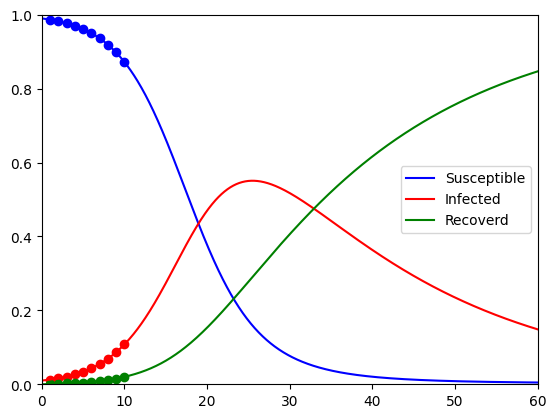

In [104]:
plt.plot(data.t_full, data.X_full[:,0], label='Susceptible', color='blue')
plt.plot(data.t_full, data.X_full[:,1], label='Infected', color='red')
plt.plot(data.t_full, data.X_full[:,2], label='Recoverd', color='green')
plt.scatter(td, Xd[:,0], color='blue')
plt.scatter(td, Xd[:,1], color='red')
plt.scatter(td, Xd[:,2], color='green')
plt.xlim(data.t_full[0], data.t_full[-1])
plt.ylim(0,1)
plt.legend()
plt.show()

### Known system $N_K$

In [105]:
class SIR(torch.nn.Module):
    
    def __init__(self, params):
        super(SIR, self).__init__()
        
        # Set the parameters
        for key, value in params.items():
            setattr(self, key, value) 

        self.log = dict()

    def forward(self, z, U):

        self.log.setdefault('beta', []).append(self.beta.item())
        self.log.setdefault('gamma', []).append(self.gamma.item())

        lhs = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        S = U[:, 0]
        I = U[:, 1]
        R = U[:, 2]

        rhs = torch.stack([
            -self.beta*S*I,
            self.beta*S*I - self.gamma*I,
            self.gamma*I
        ], dim=-1)


        # norm = torch.maximum(torch.abs(lhs), torch.abs(rhs)) + 1e-6

        return lhs - rhs


params = dict(
    beta=torch.nn.Parameter(torch.tensor(0.0)),
    gamma=torch.nn.Parameter(torch.tensor(0.0)),
    theta=theta
)

N = SIR(params)

### Problem specific UPINN functions

In [106]:
class SIR_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.sqrt(torch.mean((u_pred - data.X_full)**2) / torch.mean(data.X_full**2))
    
    # def get_loss(self):
    #     bc_loss = self.bc_loss()
    #     data_loss = self.data_loss()
    #     pde_loss = self.pde_loss()

    #     u_pred = self.u(self.collocation_points)
    #     population_loss = torch.mean((1 - torch.sum(u_pred, dim=1))**2)
        
    #     loss = self.lambdas[0]*bc_loss + self.lambdas[1]*data_loss + self.lambdas[2]*pde_loss + 1e-3*population_loss

    #     return loss, bc_loss, data_loss, pde_loss
    
    # def pde_loss(self):
    #     u_pred = self.u(self.collocation_points)
    #     lhs, rhs = self.N(self.collocation_points, u_pred)
        
    #     norm = torch.maximum(torch.abs(lhs), torch.abs(rhs)) + 1e-8
    #     res_norm = (lhs - rhs)

    #     return torch.mean(res_norm**2) + torch.mean((1-torch.sum(u_pred, dim=1))**2)
        # return torch.mean(res_norm**2)

    # def data_loss(self):
    #     u_pred = self.u(self.data_points[0])
    #     return torch.mean((u_pred[:, 1] - self.data_points[1][:, 1])**2)


    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            # Get network predictions
            u_pred = self.u(data.t_full)

            plt.plot(data.t_full, data.X_full[:,0], label='S', linestyle='--', color='b')
            plt.plot(data.t_full, data.X_full[:,1], label='I', linestyle='--', color='y')
            plt.plot(data.t_full, data.X_full[:,2], label='R', linestyle='--', color='r')
            plt.plot(data.t_full, u_pred[:,0].detach().numpy(), label='S pred', color='b')
            plt.plot(data.t_full, u_pred[:,1].detach().numpy(), label='I pred', color='y')
            plt.plot(data.t_full, u_pred[:,2].detach().numpy(), label='R pred', color='r')
            plt.legend()
            plt.show()



### Setup UPINN

In [107]:
class SIRNet(FNN):
    def forward(self, z):
        z = z/60
        z = super().forward(z)
        z = torch.nn.functional.softplus(z)
        return z / torch.sum(z, dim=1, keepdim=True)

In [108]:
# Define model architectures
hidden = [16] * 3
# u = FNN(
#     dims=[1, *hidden, 3],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Softmax(),
# )
u = SIRNet(
    dims=[1, *hidden, 3],
    hidden_act=torch.nn.Tanh(),
)

In [109]:
model = SIR_UPINN(u, N, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=tc)
# model = SIR_UPINN(u, N, boundary_points=(tbc, Xbc), collocation_points=tc)
# model = SIR_UPINN(u, N, boundary_points=(tbc, Xbc), data_points=(td, Xd))

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


### Train

In [110]:
model.to('cpu')
adam = torch.optim.Adam(model.parameters(), lr=1e-3)
model.optimizer = adam

In [116]:
model.freeze('N')

In [120]:
model.collocation_points = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid').requires_grad_(True)

In [121]:
for i in range(10):
    model.train_loop(500)
    model.score().item()
    print(model.N.log['beta'][-1], model.N.log['gamma'][-1])

[Info]: Training 500 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 68.07 epoch/s, bc_loss=1.24e-08, data_loss=3.16e-08, pde_loss=3.36e-07, loss=3.80e-07]


0.29985421895980835 0.04774349927902222
[Info]: Training 500 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 66.35 epoch/s, bc_loss=1.27e-08, data_loss=1.81e-08, pde_loss=7.24e-08, loss=1.03e-07]


0.29985421895980835 0.04774349927902222
[Info]: Training 500 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 64.80 epoch/s, bc_loss=1.29e-08, data_loss=1.51e-08, pde_loss=4.12e-08, loss=6.91e-08]


0.29985421895980835 0.04774349927902222
[Info]: Training 500 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 63.64 epoch/s, bc_loss=1.36e-08, data_loss=9.84e-08, pde_loss=2.80e-08, loss=1.40e-07]


0.29985421895980835 0.04774349927902222
[Info]: Training 500 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 59.91 epoch/s, bc_loss=1.39e-08, data_loss=1.03e-08, pde_loss=2.02e-08, loss=4.45e-08]


0.29985421895980835 0.04774349927902222
[Info]: Training 500 epoch(s) on cuda using Adam optimizer.


[CUDA]:  40%|████      | 200/500 [00:03<00:05, 55.80 epoch/s, bc_loss=1.41e-08, data_loss=9.76e-09, pde_loss=1.81e-08, loss=4.19e-08]


KeyboardInterrupt: 

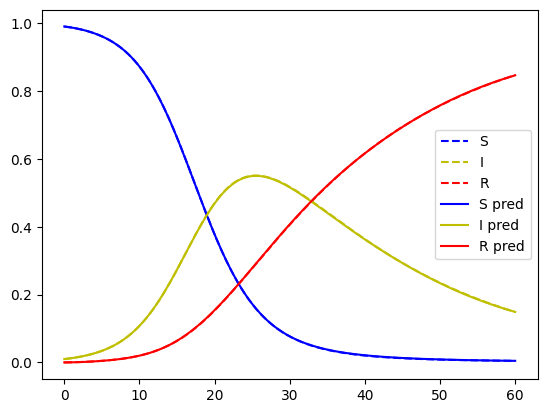

In [122]:
model.plot()

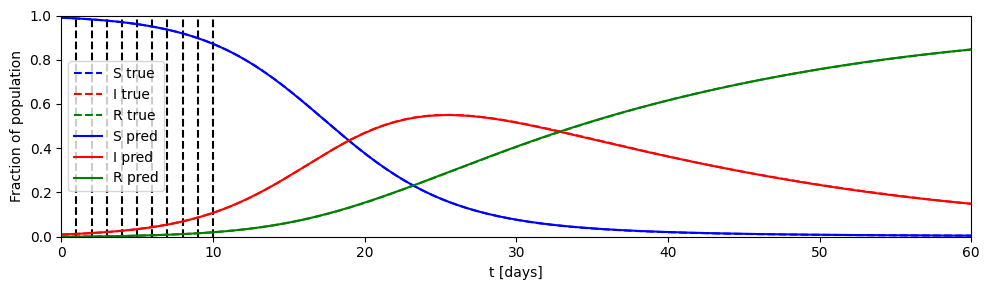

In [ ]:
model.to('cpu')
plt.figure( figsize=(10, 3))
u_pred = model.u(data.t_full)
for i in range(10):
    plt.axvline(i+1, color='k', linestyle='--', lw=0.5)
plt.plot(data.t_full, data.X_full[:,0], label='S true', linestyle='--', color='b')
plt.plot(data.t_full, data.X_full[:,1], label='I true', linestyle='--', color='r')
plt.plot(data.t_full, data.X_full[:,2], label='R true', linestyle='--', color='g')
plt.plot(data.t_full, u_pred[:,0].detach().numpy(), label='S pred', color='b')
plt.plot(data.t_full, u_pred[:,1].detach().numpy(), label='I pred', color='r')
plt.plot(data.t_full, u_pred[:,2].detach().numpy(), label='R pred', color='g')
plt.legend()
plt.xlabel('t [days]')
plt.ylabel('Fraction of population')
plt.xlim(data.t_full[0], data.t_full[-1])
plt.ylim(0,1)
# plt.savefig('gfx/sir_pinn.pdf', bbox_inches='tight', format='pdf')
plt.tight_layout()
plt.show()

In [114]:
betas = np.array(model.N.log['beta'])
gammas = np.array(model.N.log['gamma'])

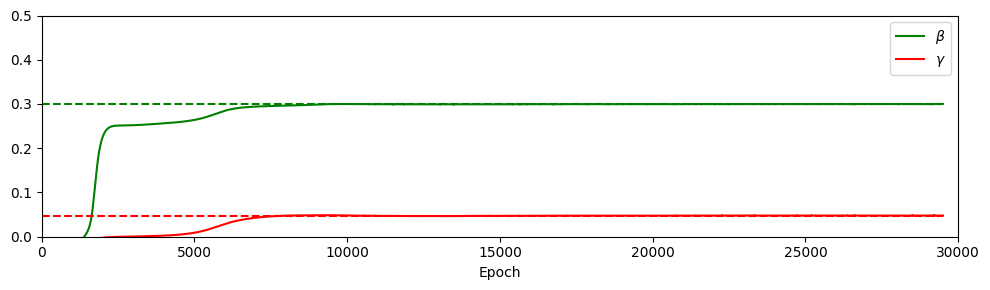

In [115]:
model.to('cpu')
plt.figure( figsize=(10, 3))
plt.plot(betas, label=r'$\beta$', color='g')
plt.plot([0, len(betas)], [beta, beta], linestyle='--', color='g')
plt.plot(gammas, label=r'$\gamma$', color='r')
plt.plot([0, len(gammas)], [gamma, gamma], linestyle='--', color='r')
plt.legend()
plt.xlabel('Epoch')
plt.xlim(0, 30000)
plt.ylim(0,0.5)
# plt.savefig('gfx/sir_pinn_inverse_params.pdf', bbox_inches='tight', format='pdf')
plt.tight_layout()
plt.show()